## Demo code

In [1]:
# coding: utf-8

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import cv2
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from tqdm import tqdm
from PIL import Image
from datetime import datetime
from scipy.misc import imread, imsave, imresize
from keras.optimizers import RMSprop
from keras.models import Model, load_model
from keras.utils import to_categorical
from models.resnet50 import ResNet50
#get_ipython().magic(u'matplotlib inline')

Using TensorFlow backend.


In [2]:
def parse_args():
    import sys
    sys.argv=['']
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Training Image Classification Model')
    parser.add_argument('--gpu', dest='gpu_id', help='GPU device id to use [0]',
                        default='0')
    parser.add_argument('--cpu', dest='cpu_mode',
                        help='Use CPU mode (overrides --gpu)',
                        action='store_true')
    parser.add_argument('--model', dest='model', help='Network to use [resnet50]',
                        default='resnet50_imagenet')
    parser.add_argument('--pretrained', dest='pretrained', help='Pretrained Custom Network to use',
                        default='pretrainedModel.h5')
    parser.add_argument('--epochs', dest='epochs', help='Number of Epochs for Training',
                        default=10, type=int)
    parser.add_argument('--save', dest='save', help='Save Model File Name',
                        default='resnet50.imagenet.h5')
    parser.add_argument('--test', dest='test_model', help='Test Model',
                        default=True, type=bool)
    parser.add_argument('--train', dest='train_data', help='Training Data Dir',
                        default='example_annotation')
    parser.add_argument('--size', dest='img_size', help='Size of Input Images (default:224 -> 224x224x3)',
                        default=224, type=int)
    parser.add_argument('--mode', dest='mode', help='Classification or Regression mode',
                        default='classification')

    args = parser.parse_args()

    return args

In [3]:
def load_data():
    data_path = os.path.join(os.getcwd(),'data',args.train_data)
    text_file = os.path.join(data_path, 'annotation.txt')
    if os.path.exists(text_file):
        return load_data_from_annotation()
    else:
        return load_data_from_categorical_folders()

In [4]:
def load_data_from_annotation():
    
    args = parse_args()
    img_col = args.img_size
    img_row = args.img_size

    data_path = os.path.join(os.getcwd(),'data',args.train_data)

    text_file = os.path.join(data_path, 'annotation.txt')
    train_data = [i.strip('\n').split('\t') for i in open(text_file)]
    num_data = len(train_data)

    imgs = []
    labels = []
    
    idxs = range(num_data)
    np.random.seed(0)
    np.random.shuffle(idxs)
    idx_count = 0
    for idx in tqdm(idxs):
        img_path = train_data[idx][0]
        label    = train_data[idx][1][:-1] # remove \r
        img_path = os.path.join(os.getcwd(), 'data', args.train_data, img_path)
        img = imread(img_path, mode='RGB')
        if img.nbytes > 10**3: # Read image file only when its size is larger than 1 kilo bytes
            img = imresize(img, (img_col, img_row, 3))
            imgs.append(img)
            labels.append(label)
        else:
            continue

    data = {'Image': imgs,
            'Label': labels}
    
    return pd.DataFrame(data)

In [5]:
def load_data_from_categorical_folders():

    args = parse_args()
    img_col = args.img_size
    img_row = args.img_size
    
    img_files = []
    labels = []
    
    data_path = os.path.join(os.getcwd(), 'data', args.train_data)
    category_idx = 0

    print 'Loading files from data folder'
    for category in tqdm(os.listdir(data_path)): # categorical subfolders in data folder
        img_path = os.path.join(data_path, category)
        img_count = 0
        for img_file in os.listdir(img_path):
            is_image = (img_file.endswith('png') or
                        img_file.endswith('PNG') or
                        img_file.endswith('jpg') or
                        img_file.endswith('JPG') or
                        img_file.endswith('jpeg') or
                        img_file.endswith('JPEG') or
                        img_file.endswith('gif') or
                        img_file.endswith('GIF') or
                        img_file.endswith('tif') or
                        img_file.endswith('TIF'))
                        
            if is_image:
                img_count += 1
                img_files.append(os.path.join(img_path, img_file))
                labels.append(category)

        subcategory = [os.path.join(img_path, subfolder) for subfolder in os.listdir(img_path) if os.path.isdir(os.path.join(img_path,subfolder))]
        for subcat in subcategory:
            sub_path = os.path.join(img_path, subcat)
            for img_file in os.listdir(sub_path):
                is_image = (img_file.endswith('png') or
                            img_file.endswith('PNG') or
                            img_file.endswith('jpg') or
                            img_file.endswith('JPG') or
                            img_file.endswith('jpeg') or
                            img_file.endswith('JPEG') or
                            img_file.endswith('gif') or
                            img_file.endswith('GIF') or
                            img_file.endswith('tif') or
                            img_file.endswith('TIF'))
                if is_image:
                    img_count += 1
                    img_files.append(os.path.join(img_path, img_file))
                    labels.append(category)
    imgs = []
    new_labels = []
    num_data = len(img_files)
    idxs = range(num_data)
    np.random.seed(0)
    np.random.shuffle(idxs)
    print 'Image reading from files'
    for idx in tqdm(idxs):
        img_path = img_files[idx]
        label    = labels[idx]
        img = imread(img_path, mode='RGB')
        if img.nbytes > 10**3: # Read image file only when its size is larger than 1 kilo bytes
            img = imresize(img, (img_col, img_row, 3))
            imgs.append(img)
            new_labels.append(label)
        else:
            continue

    data = {'Image': imgs,
            'Label': new_labels}
    return pd.DataFrame(data)

In [6]:
def label_to_categorical(labels, label_dict=None, mode='to_categorical'):
    if mode == 'to_categorical':
        label_dict, ids = np.unique(labels, return_inverse=True)
        output = to_categorical(ids, len(label_dict))
    else:
        output = label_dict[labels.argmax(1)]
        output = output[0]
    return output, label_dict

In [7]:
def construct_data(frame):
    args    = parse_args()
    img_col = args.img_size
    img_row = args.img_size
    inputData   = np.asarray([im for im in frame['Image'].as_matrix()])
    outputData, label_dict  = label_to_categorical(frame['Label'])
    input_shape = (img_col, img_row, 3)
    return inputData, outputData, input_shape, label_dict

In [8]:
def get_model(input_shape, class_num):
    args = parse_args()
    
    if args.model == 'resnet50':
        model = ResNet50(include_top=True, weights=None,
                         input_tensor=None, input_shape=input_shape,
                         pooling=None, mode=args.mode,
                         classes=class_num)
        
    elif args.model == 'resnet50_imagenet':
        model = ResNet50(include_top=True, weights='imagenet',
                         input_tensor=None, input_shape=input_shape,
                         pooling=None, mode=args.mode,
                         classes=class_num)
        
    elif args.model == 'pretrained':
        modelName = os.path.join(os.getcwd(), 'weights', args.pretrained)
        model = load_model(modelName)
        
    rmsprop = RMSprop(lr=1e-05, rho=0.99, epsilon=1e-08, decay=0.001)
    model.compile(optimizer=rmsprop,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    print model.summary()
    
    return model

In [9]:
def train_model(model, batch_size=10):
    args = parse_args()
    epochs = args.epochs
    weightDir = os.path.join(os.getcwd(), 'weights', args.model)
    if not os.path.exists(weightDir):
        os.makedirs(weightDir)
    filepath = weightDir + '/weights.epoch_{epoch:02d}.val-loss_{val_loss:.2f}.h5'
    modelChackpt = keras.callbacks.ModelCheckpoint(filepath,
                                                   monitor='val_loss',
                                                   verbose=0,
                                                   save_best_only=True,
                                                   save_weights_only=False,
                                                   mode='auto',
                                                   period=10)
    time_start = datetime.now()
    print '** Training Start, {}'.format(time_start.strftime('%Y-%m-%d %H:%M:%S'))
    history = model.fit(inputData, outputData,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.2,
              shuffle=True,
              callbacks=[modelChackpt])
    time_end = datetime.now()
    print '** Training Done, {}'.format(time_end.strftime('%Y-%m-%d %H:%M:%S'))
    time_elapsed = str(time_end - time_start).split(':')
    print '**** Elapsed Time : {} hours {} minutes'.format(time_elapsed[0], time_elapsed[1])
    
    modelName = os.path.join(os.getcwd(), 'weights', args.save)
    model.save(modelName)
    print '** Model Saved at [{}] ...'.format(modelName)

In [15]:
def test_model(label_dict, sample_num=4):
    print '**** Start testing the model'
    args = parse_args()
    img_col = args.img_size
    img_row = args.img_size
    
    modelName = os.path.join(os.getcwd(), 'weights', args.save)
    model = load_model(modelName)
    
    num_data = len(frame['Label'])
    
    idxs = range(int(num_data*0.8), num_data)
    np.random.seed(0)
    np.random.shuffle(idxs)
    if len(idxs) < sample_num:
        sample_num = len(idxs)
        
    idx_count = 0
    right = 0
    
    fig_col  = int(np.ceil(sample_num/2.))
    fig_row  = 2
    fig_size = 6
    f1 = plt.figure(figsize=(fig_row*fig_size, fig_col*fig_size))
    
    for idx in tqdm(idxs):
        plt.subplot(fig_col,fig_row,idx_count+1)
        plt.axis('off')
        img = frame['Image'][idx]
        input_img = np.reshape(img, (1, img_col, img_row, 3))
        predict = model.predict(input_img)
        
        target_label = frame['Label'][idx]
        predicted_label = label_to_categorical(predict,label_dict,'reverse')
        predicted_label = predicted_label[0]
        if predicted_label == target_label:
            right += 1
        plt.title('Groundtruth : {}\nPredicted   : {}'.format(target_label, predicted_label))
        _ = plt.imshow(img)
        idx_count += 1
        if idx_count >= sample_num:
            break
    print '** Accuracy : {} ({} / {})'.format(right*100./sample_num, right, idx_count)
    plt.show()
    now = datetime.now()
    nowDatetime = now.strftime('%Y_%m_%d-%H%M%S')
    imgResultFileName = os.path.join(os.getcwd(), 'result', nowDatetime + '_' + args.save + '.png')
    f1.savefig(imgResultFileName, dpi=100)
    print '**** Result Image Saved at [{}] ...'.format(imgResultFileName)

In [11]:
args = parse_args()
frame = load_data()
inputData, outputData, input_shape, label_dict = construct_data(frame)

  0%|          | 0/20 [00:00<?, ?it/s]__main__:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
__main__:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|██████████| 20/20 [00:00<00:00, 219.00it/s]


In [12]:
model = get_model(input_shape=input_shape, class_num=len(outputData[0]))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [13]:
train_model(model)

** Training Start, 2018-04-05 15:26:44
Train on 16 samples, validate on 4 samples
Epoch 1/10
16/16 [==============================] - 5s 331ms/step - loss: 0.5752 - categorical_accuracy: 0.6875 - val_loss: 0.1943 - val_categorical_accuracy: 1.0000
Epoch 2/10
16/16 [==============================] - 0s 22ms/step - loss: 0.0070 - categorical_accuracy: 1.0000 - val_loss: 0.1932 - val_categorical_accuracy: 1.0000
Epoch 3/10
16/16 [==============================] - 0s 22ms/step - loss: 0.0089 - categorical_accuracy: 1.0000 - val_loss: 0.1915 - val_categorical_accuracy: 1.0000
Epoch 4/10
16/16 [==============================] - 0s 22ms/step - loss: 0.0134 - categorical_accuracy: 1.0000 - val_loss: 0.1890 - val_categorical_accuracy: 1.0000
Epoch 5/10
16/16 [==============================] - 0s 22ms/step - loss: 0.0283 - categorical_accuracy: 1.0000 - val_loss: 0.1811 - val_categorical_accuracy: 1.0000
Epoch 6/10
16/16 [==============================] - 0s 22ms/step - loss: 0.0041 - categorica

**** Start testing the model


 75%|███████▌  | 3/4 [00:01<00:00,  1.55it/s]


** Accuracy : 100.0 (4 / 4)


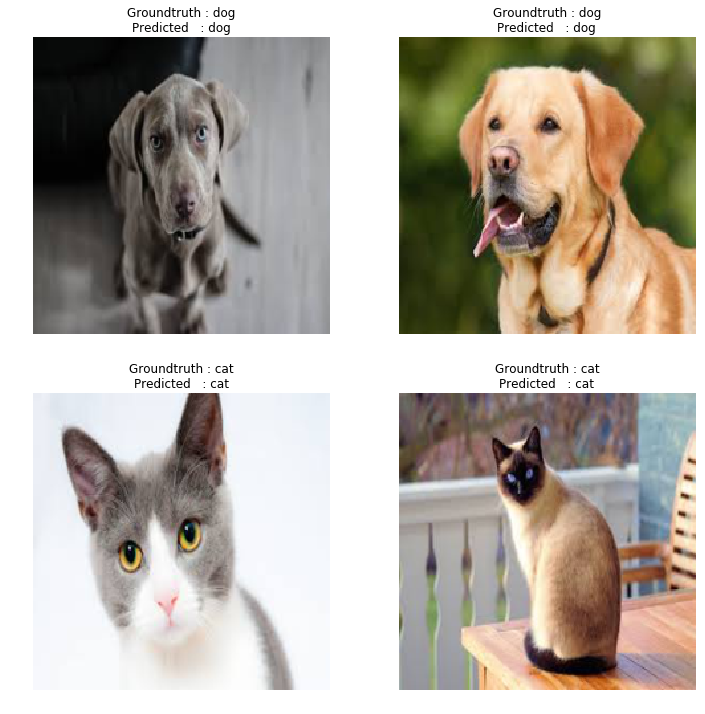

**** Result Image Saved at [/data1/home/hmroh/publish/git_repository/ImageClassification/result/2018_04_05-152927_resnet50.imagenet.h5.png] ...


In [16]:
test_model(label_dict)